# Predicting sales for Rossman stores: pipeline

In this notebook we'll present the devopment of our model.

In [1]:
# importing user defined functions
from data_cleaning_rossman import clean_rossman
from feature_eng import feat_eng
from utils import metric

# importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import warnings

In [2]:
# ignore future warning  when using TargetEnconder()
warnings.filterwarnings("ignore", category=FutureWarning)

# Data cleaning

The function `clean_rossman()` performs some inital cleaning tasks on the data.
It takes as input a timeseries csv file, a csv with store info and the directory where the
two csv files can be found.
The function will read the csv files as a pandas Dataframe. First the two Dataframes will be merged on the Store column, with a left join to not lose any data.
The cleaning functions performed are:
* Replace missing values for Customers data with the median of the column
* Drop all rows without a store id or a sales value as we don't have any info in that case
* Drop the Open Column since we assume the store is open on days when there are sales
* Fill in the missing values of the DayOfWeek column based on the Date
* Drop the rows with missing values from the Promo column
* Replace all the missing values from StateHoliday and Schoolholiday with the most frequent value of the column
* Replace all the missing values from the CompetitionDistance column with the most frequent distance for that store
* Change the missing values in the PromoInterval to a 'No Promo' string to be able to use them in the feature engineering
* If we are cleaning the train Dataframe, the second percentile outliers get removed from the Sales and Customers columns

In [3]:
# clean the data
train_cleaned = clean_rossman(csv_tseries='train.csv', csv_store='store.csv', data_folder='data')

In [4]:
# clean the data
holdout_cleaned = clean_rossman(csv_tseries='holdout.csv', csv_store='store.csv', data_folder='data')

# Feature engineering

The user function `feat_eng()` performs some engineering tasks having as input a pandas dataframe. The main tasks performed by this function are:
* Create new features (year, day of the month and week of the year) from the `Date` column and
     when change type when necessary
* Create a new feature dividing the Sales per Customer per Store
* Apply one-hot and target enconding to some categorical features
* Drop some features
The user can choose to work with the train or the test file through the parameter train_data.

In [5]:
# engineering features
train_eng, te_store, te_week, te_day = feat_eng(train_cleaned, train_data=True, te_store=None, te_week=None, te_day=None)

In [6]:
# engineering features
holdout_eng, te_store, te_week, te_day = feat_eng(holdout_cleaned, train_data=False, te_store=te_store, te_week=te_week, te_day=te_day)

In [7]:
# show the first lines of the train
train_eng.head(3)

,Sales,Promo,CompetitionDistance,Promo2,StateHoliday_0,StateHoliday_a,StateHoliday_b,StateHoliday_c,SchoolHoliday_0,SchoolHoliday_1,...,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7,Store_target,WeekofYear_target,Day_target
27,3139,0,900,1,0,1,0,0,0,1,...,0,1,0,0,0,0,0,5104.747082,5852.078279,6798.600823
115,2401,0,90,1,0,1,0,0,0,1,...,0,1,0,0,0,0,0,8061.232558,5852.078279,6798.600823
147,2646,0,590,1,0,1,0,0,0,1,...,0,1,0,0,0,0,0,5161.451883,5852.078279,6798.600823


In [8]:
# show the first lines of the holdout
holdout_eng.head(3)

,Sales,Promo,CompetitionDistance,Promo2,StateHoliday_0,StateHoliday_a,StateHoliday_b,StateHoliday_c,SchoolHoliday_0,SchoolHoliday_1,...,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7,Store_target,WeekofYear_target,Day_target
0,7195,1,1970,1,1,0,0,0,0,1,...,0,0,0,0,1,0,0,6843.828979,7760.831193,6798.600823
1,9525,1,4880,1,1,0,0,0,0,1,...,0,0,0,0,1,0,0,8365.822581,7760.831193,6798.600823
2,5621,1,11120,1,1,0,0,0,0,1,...,0,0,0,0,1,0,0,4349.109840,7760.831193,6798.600823


# Modeling

In [9]:
# importing libraries
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.ensemble import RandomForestRegressor

In [10]:
# separating features and target variable from train.csv

# matrix of features, X
X_train = train_eng.drop('Sales', axis=1)  
# target variable vector, y
y_train = train_eng['Sales']               

# matrix of features, X
X_test = holdout_eng.drop('Sales', axis=1)  
# target variable vector, y
y_test = holdout_eng['Sales']               

# Decision tree

In [11]:
# build the decision tree using default settings
dt_model = DecisionTreeRegressor()
dt_model.fit(X_train, y_train)

DecisionTreeRegressor()

In [12]:
# prediction
y_pred = dt_model.predict(X_test)

In [13]:
# calculating the metrics
rmspe = metric(np.array(y_pred), np.array(y_test))
print(f'RMSE(decision tree) = {round(rmspe, 1)}%')

RMSE(decision tree) = 28.0%


In [14]:
# create a datraframe containing predicted and actual values
pred_actual = pd.DataFrame({'predictions':y_pred,'actual values':y_test})
pred_actual = pred_actual.reset_index(drop=True)
pred_actual.head(3)

,predictions,actual values
0,6749.0,7195
1,8695.0,9525
2,5160.0,5621


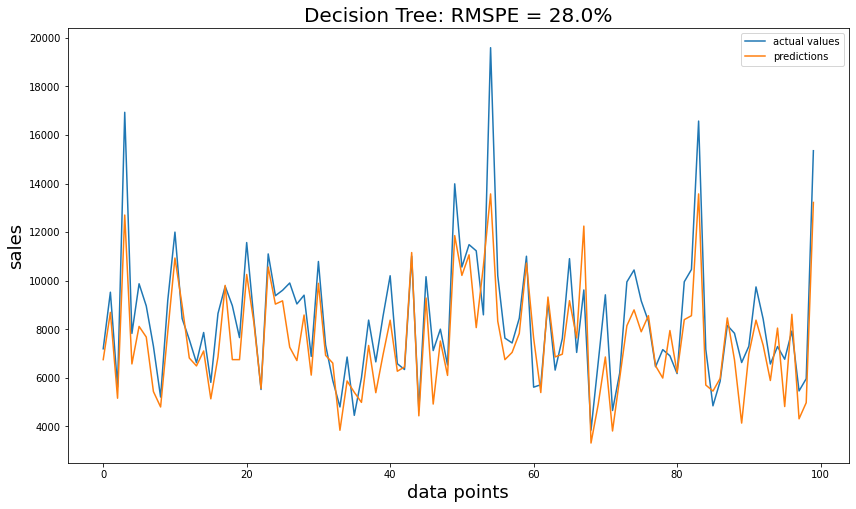

In [15]:
# use previously created dataframe to make a plot
# comparing predictions with actual values for the first n datapoints
n_points = 100

plt.figure(figsize=(14,8))
pred_actual["actual values"][:n_points,].plot.line()
pred_actual["predictions"][:n_points,].plot.line()
plt.title(f'Decision Tree: RMSPE = {round(rmspe, 1)}%', size=20)
plt.xlabel('data points', size=18)
plt.ylabel('sales', size=18)
plt.legend()
plt.show()

# Random Forest

In [16]:
# build the Random Forest model using default settings
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

RandomForestRegressor()

In [17]:
# prediction
y_pred = rf.predict(X_test)

In [18]:
# calculating the metrics
rmspe = metric(np.array(y_pred), np.array(y_test))
print(f'RMSE(random forest) = {round(rmspe, 1)}%')

RMSE(random forest) = 25.6%


In [19]:
# create a datraframe containing predicted and actual values
pred_actual = pd.DataFrame({'predictions':y_pred,'actual values':y_test})
pred_actual = pred_actual.reset_index(drop=True)
pred_actual.head(3)

,predictions,actual values
0,7444.36,7195
1,9075.11,9525
2,4881.03,5621


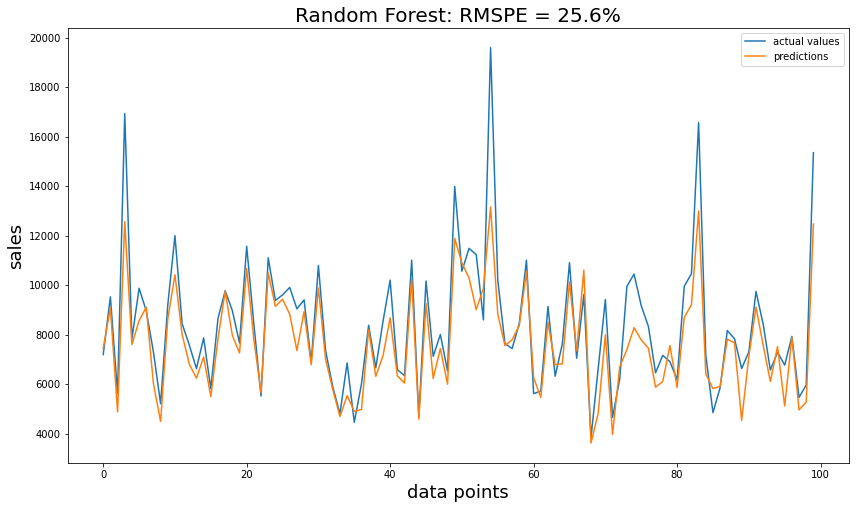

In [20]:
# use previously created dataframe to make a plot
# comparing predictions with actual values for the first n datapoints
n_points = 100

plt.figure(figsize=(14,8))
pred_actual["actual values"][:n_points,].plot.line()
pred_actual["predictions"][:n_points,].plot.line()
plt.title(f'Random Forest: RMSPE = {round(rmspe, 1)}%', size=20)
plt.xlabel('data points', size=18)
plt.ylabel('sales', size=18)
plt.legend()
plt.show()

# XGBoost

In [21]:
# build the XGBoost model using default settings
xgb_base = XGBRegressor(random_state=42)

xgb_base.fit(X_train,y_train)

# prediction
y_pred = xgb_base.predict(X_test)

In [22]:
# calculating the metrics
rmspe = metric(np.array(y_pred), np.array(y_test))
print(f'RMSE(XGBoost) = {round(rmspe, 1)}%')

RMSE(XGBoost) = 23.9%


In [23]:
# create a datraframe containing predicted and actual values
pred_actual = pd.DataFrame({'predictions':y_pred,'actual values':y_test})
pred_actual = pred_actual.reset_index(drop=True)
pred_actual.head(3)

,predictions,actual values
0,8116.102051,7195
1,10069.926758,9525
2,4750.463867,5621


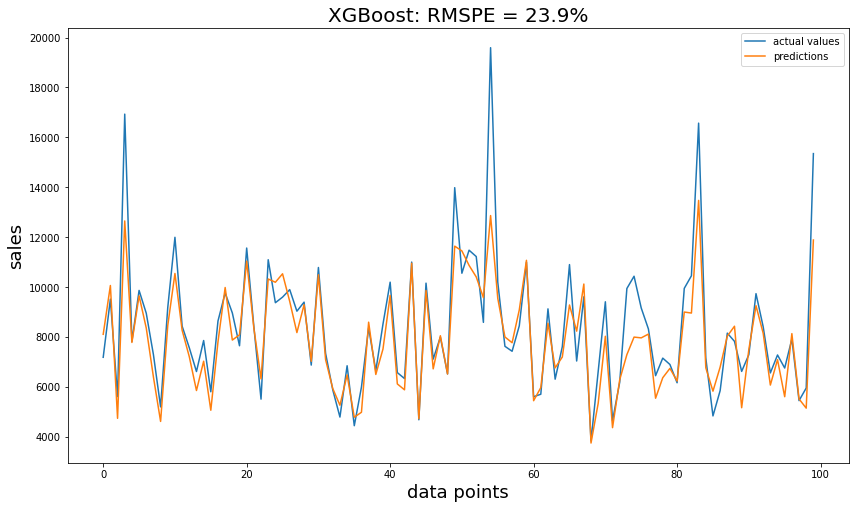

In [24]:
# use previously created dataframe to make a plot
# comparing predictions with actual values for the first n datapoints
n_points = 100

plt.figure(figsize=(14,8))
pred_actual["actual values"][:n_points,].plot.line()
pred_actual["predictions"][:n_points,].plot.line()
plt.title(f'XGBoost: RMSPE = {round(rmspe, 1)}%', size=20)
plt.xlabel('data points', size=18)
plt.ylabel('sales', size=18)
plt.legend()
plt.show()

In [25]:
# removing selected features to see if it improves the model
X_train = X_train.drop(['StateHoliday_a', 
                        'StateHoliday_b', 
                        'StateHoliday_c', 
                        'PromoInterval_No Promo', 
                        'SchoolHoliday_1'], 
                       axis=1)

X_test = X_test.drop(['StateHoliday_a', 
                        'StateHoliday_b', 
                        'StateHoliday_c', 
                        'PromoInterval_No Promo', 
                        'SchoolHoliday_1'], 
                       axis=1)

In [26]:
# build the XGBoost model after removing selected features
xgb_sel = XGBRegressor(random_state=42)
xgb_sel.fit(X_train, y_train)

# prediction
y_pred = xgb_sel.predict(X_test)

In [27]:
# calculating the metrics
rmspe = metric(np.array(y_pred), np.array(y_test))
print(f'RMSE(XGBoost/features removed) = {round(rmspe, 1)}%')

RMSE(XGBoost/features removed) = 24.2%


# Summarizing the results

|Algorithm                 | RMSPE (%)|
|--------------------------|:--------:|
|Decision Tree             | 28.0     |
|Random Forest             | 25.6     |
|XGBoost                   | 23.9     |
|XGBoost(features removed) | 24.2     |

* The best result was achieved with XGBoost. 
* The performance can be improved by tuning the hyperparameters. 